In [0]:
# -*- coding: utf-8 -*-
#https://github.com/teddykoker/blog/blob/master/_notebooks/2019-04-21-simulating-historical-performance-of-leveraged-etfs-in-python.ipynb

In [0]:

#https://github.com/teddykoker/blog/blob/master/_notebooks/2019-04-21-simulating-historical-performance-of-leveraged-etfs-in-python.ipynb

In [16]:
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
import pandas_datareader.data as web    #import pandas_datareader.data as web           
import datetime
%matplotlib inline

In [17]:
def returns(prices):
    """
    Calulates the growth of 1 dollar invested in a stock with given prices
    """
    return (1 + prices.pct_change(1)).cumprod()

def drawdown(prices):
    """
    Calulates the drawdown of a stock with given prices
    """
    rets = returns(prices)
    return (rets.div(rets.cummax()) - 1) * 100

def cagr(prices):
    """
    Calculates the Compound Annual Growth Rate (CAGR) of a stock with given prices
    """
    delta = (prices.index[-1] - prices.index[0]).days / 365.25
    return ((prices[-1] / prices[0]) ** (1 / delta) - 1) * 100


In [18]:
start = datetime.datetime(2009, 6, 23)
end = datetime.datetime(2019, 1, 1)

In [19]:
spy = web.DataReader("SPY", "yahoo", start, end)["Adj Close"]
upro = web.DataReader("UPRO", "yahoo", start, end)["Adj Close"]

/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, 

In [20]:
spy_returns = returns(spy).rename("SPY")
upro_returns = returns(upro).rename("UPRO")

/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/blocks.py:1205: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fill_value = convert_scalar(self.values, fill_value)


/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

<AxesSubplot:title={'center':'Growth of $1: SPY vs UPRO'}, xlabel='Date'>

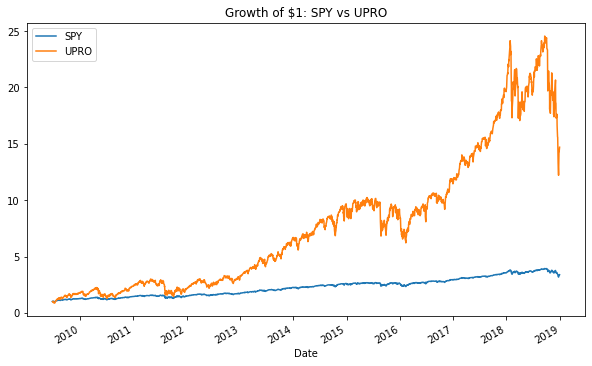

In [21]:
spy_returns.plot(title="Growth of $1: SPY vs UPRO", legend=True, figsize=(10,6))
upro_returns.plot(legend=True)

In [22]:
print("CAGRs")
print(f"SPY: {cagr(spy):.2f}%")
print(f"UPRO: {cagr(upro):.2f}%")

CAGRs
SPY: 13.67%
UPRO: 32.63%


In [28]:
spy_drawdown = drawdown(spy)

In [29]:
upro_drawdown = drawdown(upro)

Max Drawdown
SPY: 2018-12-24 00:00:00 -19.35%
UPRO: 2011-10-03 00:00:00 -51.73%


/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/blocks.py:962: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new = convert_scalar(new_values, new)
/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

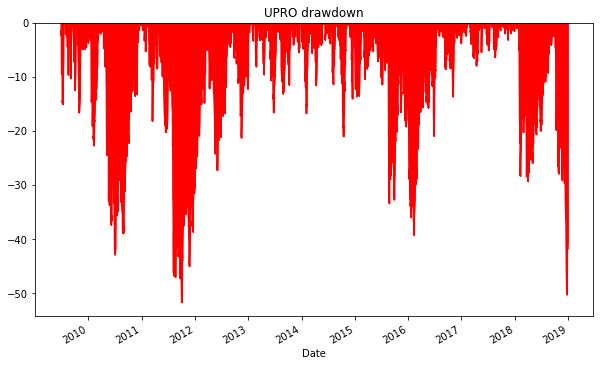

In [30]:
print("Max Drawdown")
print(f"SPY: {spy_drawdown.idxmin()} {spy_drawdown.min():.2f}%")
print(f"UPRO: {upro_drawdown.idxmin()} {upro_drawdown.min():.2f}%")
upro_drawdown.plot.area(color="red", title="UPRO drawdown", figsize=(10,6));

In [31]:
#Simulating Historical Performance
def sim_leverage(proxy, leverage=1, expense_ratio = 0.0, initial_value=1.0):
    pct_change = proxy.pct_change(1)
    pct_change = (pct_change - expense_ratio / 252) * leverage
    sim = (1 + pct_change).cumprod() * initial_value
    sim[0] = initial_value
    return sim

/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/blocks.py:1205: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fill_value = c

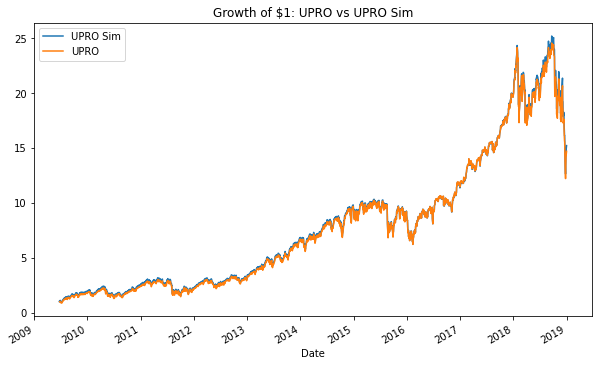

In [32]:
vfinx = web.DataReader("VFINX", "yahoo", start, end)["Adj Close"]
upro_sim = sim_leverage(vfinx, leverage=3.0, expense_ratio=0.0092).rename("UPRO Sim")
upro_sim.plot(title="Growth of $1: UPRO vs UPRO Sim", legend=True, figsize=(10,6))
upro_returns.plot(legend=True);

/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/blocks.py:1205: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fill_value = c

CAGRs
VFINX: 10.39%
UPRO Sim: 18.75%


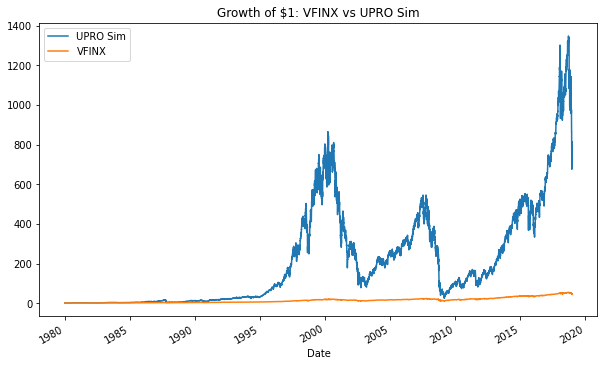

In [33]:
start = datetime.datetime(1976, 8, 31)
vfinx = web.DataReader("VFINX", "yahoo", start, end)["Adj Close"]
upro_sim = sim_leverage(vfinx, leverage=3.0, expense_ratio=0.0092).rename("UPRO Sim")
upro_sim.plot(title="Growth of $1: VFINX vs UPRO Sim", legend=True, figsize=(10,6))

vfinx_returns = returns(vfinx).rename("VFINX")
vfinx_returns.plot(legend=True)

print("CAGRs")
print(f"VFINX: {cagr(vfinx):.2f}%")
print(f"UPRO Sim: {cagr(upro_sim):.2f}%")

/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/blocks.py:1205: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fill_value = convert_scalar(self.values, fill_value)
/data/dataiku/data_dir_design/code-envs/python/finance/lib64/python3.7/site-packages/pandas/core/internals/blocks.py:962: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance:

Max Drawdown
VFINX: 2009-03-09 00:00:00 -55.25%
UPRO Sim: 2009-03-09 00:00:00 -97.11%


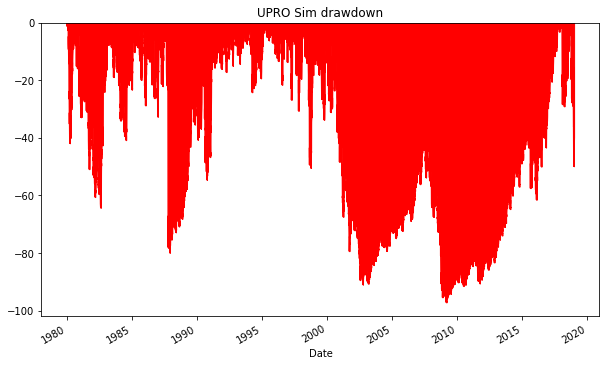

In [34]:
upro_sim_drawdown = drawdown(upro_sim)
vfinx_drawdown = drawdown(vfinx)

print("Max Drawdown")
print(f"VFINX: {vfinx_drawdown.idxmin()} {vfinx_drawdown.min():.2f}%")
print(f"UPRO Sim: {upro_sim_drawdown.idxmin()} {upro_sim_drawdown.min():.2f}%")
upro_sim_drawdown.plot.area(color="red", title="UPRO Sim drawdown", figsize=(10,6));

In [0]:
#VFINX does have a fairly substantial drawdown of over 55%, but an investor holding the simulated UPRO would 
#encounter many large drawdowns including one over 97% during the financial crisis in 2008!
#

In [0]:

#Conclusion
#The simulated UPRO had an average compound annual growth rate of 18.76% compared to the 10.39% of the S&P 500.
#Although the returns are higher, the near 100% drawdowns make it an extremely risky investment to be held on its own. 
#In the next post we will explore simulated historical performance of other leveraged ETFs and look 
#at some multi-asset allocation strategies.

In [0]:
# Write recipe outputs
test3 = dataiku.Dataset("test3")
test3.write_with_schema(test3_df)